# 1.Business Understanding




#### Concept and Motivation

In financial markets, optimizing trading decisions can significantly improve investment returns. Our goal is to develop a trading bot that automates the trading process by identifying potential buying and selling opportunities. This trading bot is based on machine learning technology and is able to predict highs and lows in the market as buying and selling opportunities.

#### Definition of High and Low

In this project, "High"  and "Low" refer to the local high and low price of the stock. I used argrelextrema to define the high and low points and then used machine learning to predict these high points date and low points date, these points represent potential sell and buy signals.

#### Data Retrieval and Annotation

Data comes from the Yahoo Finance API and includes historical stock prices and trading volumes. I preprocessed and cleaned the data, including measuring its Trend indicators, Momentum indicator, Volume indicator and Volatility indicator using the Talib technology package. Then I take the last ten days of price movement to mark the stock's direction. Finally, the Hang Seng Index was also referred to to complete its missing values.

#### Application of Machine Learning Models

I use 4 machine learning models: Random Forest, SVM, Logistic Regression and Decision Tree. These models were chosen because of their strong performance in handling nonlinear problems and avoiding overfitting. They predict whether each trading day will be a high or a low, and output the accuracy and F1 score as a reference. Finally, Random Forest was selected as the prediction model for actual performance.

#### Training and Validation

These models are trained on historical data and optimized by changing parameters. During the validation process, I monitor performance metrics such as accuracy, recall, and F1 score to ensure the model's ability to generalize.

#### Trading Mechanism

Trading decisions are based on buy signals predicted by the model,and each transaction involves a fixed number of shares (100 shares). Sell signals are divided into 4 different strategies and set different stop loss and take profit points to manage risk. Finally, there are also direct predictions of buying and selling signals based on the model as a reference strategy, demonstrating the different profitability of each strategy.



# 2. Data retrieving and processing

### Import library

In [ ]:
# Install the TA-Lib C library in Google Colab
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%cd ..
!rm -rf ta-lib ta-lib-0.4.0-src.tar.gz

--2024-04-25 10:24:41--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-04-25 10:24:42--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://unlimited.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-04-25 10:24:42--  http://unlimited.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resol

In [ ]:
!pip install TA-Lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for TA-Lib: filename=TA_Lib-0.4.28-cp310-cp310-linux_x86_64.whl size=2017537 sha256=1c5404de47faa37a8d3039b6ee23d9d5d4e043f8e70f560ee9e781c366c8cb7f
  Stored in directory: /root/.cache/pip/wheels/66/54/9d/10bfd00931c0c993f373269d350635df520b5064e5290a9d94
Successfully built TA-Lib


In [ ]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math
from sklearn.preprocessing   import MinMaxScaler
from sklearn import metrics
import talib
import random

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from scipy.signal import argrelextrema

## Import all data

In [ ]:
import yfinance as yf
import pandas as pd

# Download historical data for Tencent (0700.HK) from 2015-01-01 to 2020-12-31
data = yf.download(tickers='0700.HK',
                   start='2015-01-01',
                   end='2022-01-01',
                   interval='1d',
                   auto_adjust=True)

df = pd.DataFrame(data)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,101.476651,101.476651,99.422106,100.762024,11783333
2015-01-05,101.387314,102.995217,100.762015,101.387314,23657688
2015-01-06,101.833955,107.640276,101.476642,107.193634,47380755
2015-01-07,110.320129,111.213405,109.516174,111.124077,44327302
2015-01-08,113.893233,114.161218,112.196002,113.714577,38660017
...,...,...,...,...,...
2021-12-24,426.816805,426.816805,418.072797,419.165802,10313242
2021-12-28,416.979805,418.254962,405.321118,410.239624,20555921
2021-12-29,404.045942,405.867616,401.131263,405.138947,10402269


## Label (define 'high' or 'low'  )

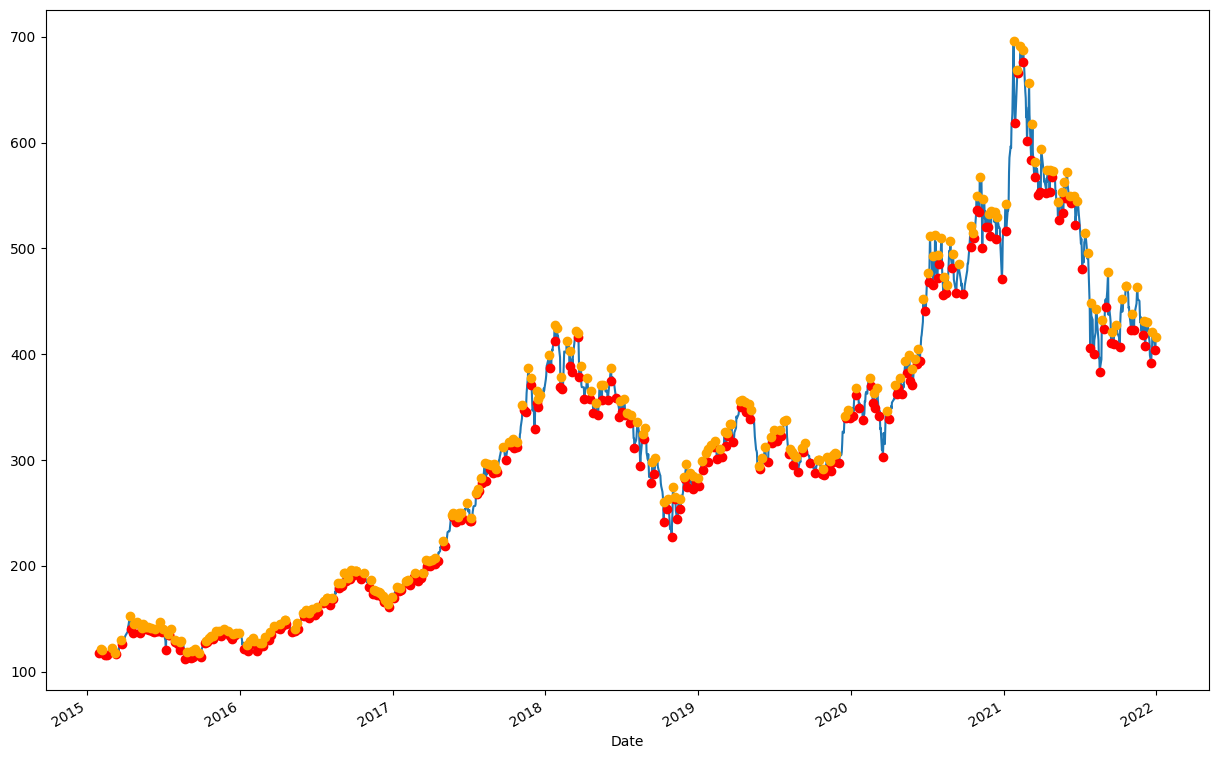

In [ ]:
n = 2
plt.figure(figsize=(15, 10))

ax = df['Close'].plot()

df.iloc[argrelextrema(df.Close.values, np.less_equal, order=n)]['Close'].plot(style='o', color='red', ax=ax)

df.iloc[argrelextrema(df.Close.values, np.greater_equal, order=n)]['Close'].plot(style='o', color='orange', ax=ax)

plt.show()

In [ ]:
# Find local highs and lows
local_max_idx = argrelextrema(df.Close.values, np.greater_equal, order=n)[0]
local_min_idx = argrelextrema(df.Close.values, np.less_equal, order=n)[0]

# Convert integer positions to index labels
local_max_labels = df.iloc[local_max_idx].index
local_min_labels = df.iloc[local_min_idx].index

# Suggestion 1: Create a 3-class classification column
df['Label'] = 0  # Default label
df.loc[local_min_labels, 'Label'] = 1  # Local lows
df.loc[local_max_labels, 'Label'] = 2  # Local highs
# Suggestion 2: Create two binary classification columns
df['High_date'] = 0
df['Low_date'] = 0
df.loc[local_max_labels, 'High_date'] = 1
df.loc[local_min_labels, 'Low_date'] = 1
#Suggestion 3: predict the price movement direction(+/-)
#The direction of price movement during each day
data['Price_Movement'] = data['Close'].diff()

# 3. Feature selection


## Feature engineering

### TA-Lib package

#### Trend indicators (EMA, Bollinger Bands)

In [ ]:
# EMA - Exponential Moving Average
df['EMA']= talib.EMA(data['Close'], timeperiod=20)

# Modified Bollinger Bands using EMA as middle band
df['Upper'], _, df['Lower'] = talib.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)


#### Momentum indicator (Stochastic Oscillator)

In [ ]:
# Stochastic Oscillator
df['k'], df['d'] = talib.STOCH(data['High'], data['Low'], data['Close'], fastk_period=14, slowk_period=3, slowd_period=3)


#### Volume indicator (OBV, On-Balance Volume)

In [ ]:
# OBV - On-Balance Volume
df['OBV'] = talib.OBV(data['Close'], data['Volume'])


#### Volatility indicator (ATR, Average True Range)

In [ ]:
# ATR - Average True Range
df['ATR'] = talib.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
df

,Open,High,Low,Close,Volume,Label,High_date,Low_date,EMA,Upper,Lower,k,d,OBV,ATR
Date,,,,,,,,,,,,,,,
2015-01-02,101.476651,101.476651,99.422106,100.762024,11783333,1,0,1,NaN,NaN,NaN,NaN,NaN,11783333.0,NaN
2015-01-05,101.387314,102.995217,100.762015,101.387314,23657688,0,0,0,NaN,NaN,NaN,NaN,NaN,35441021.0,NaN
2015-01-06,101.833955,107.640276,101.476642,107.193634,47380755,0,0,0,NaN,NaN,NaN,NaN,NaN,82821776.0,NaN
2015-01-07,110.320129,111.213405,109.516174,111.124077,44327302,0,0,0,NaN,NaN,NaN,NaN,NaN,127149078.0,NaN
2015-01-08,113.893233,114.161218,112.196002,113.714577,38660017,2,1,0,NaN,NaN,NaN,NaN,NaN,165809095.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,426.816805,426.816805,418.072797,419.165802,10313242,0,0,0,417.235404,437.848098,395.565001,49.999974,34.914508,568228496.0,12.180250
2021-12-28,416.979805,418.254962,405.321118,410.239624,20555921,0,0,0,416.569139,437.376808,394.943291,54.743562,47.435869,547672575.0,12.299138
2021-12-29,404.045942,405.867616,401.131263,405.138947,10402269,0,0,0,415.480550,437.212376,393.777904,43.846123,49.529886,537270306.0,12.071226


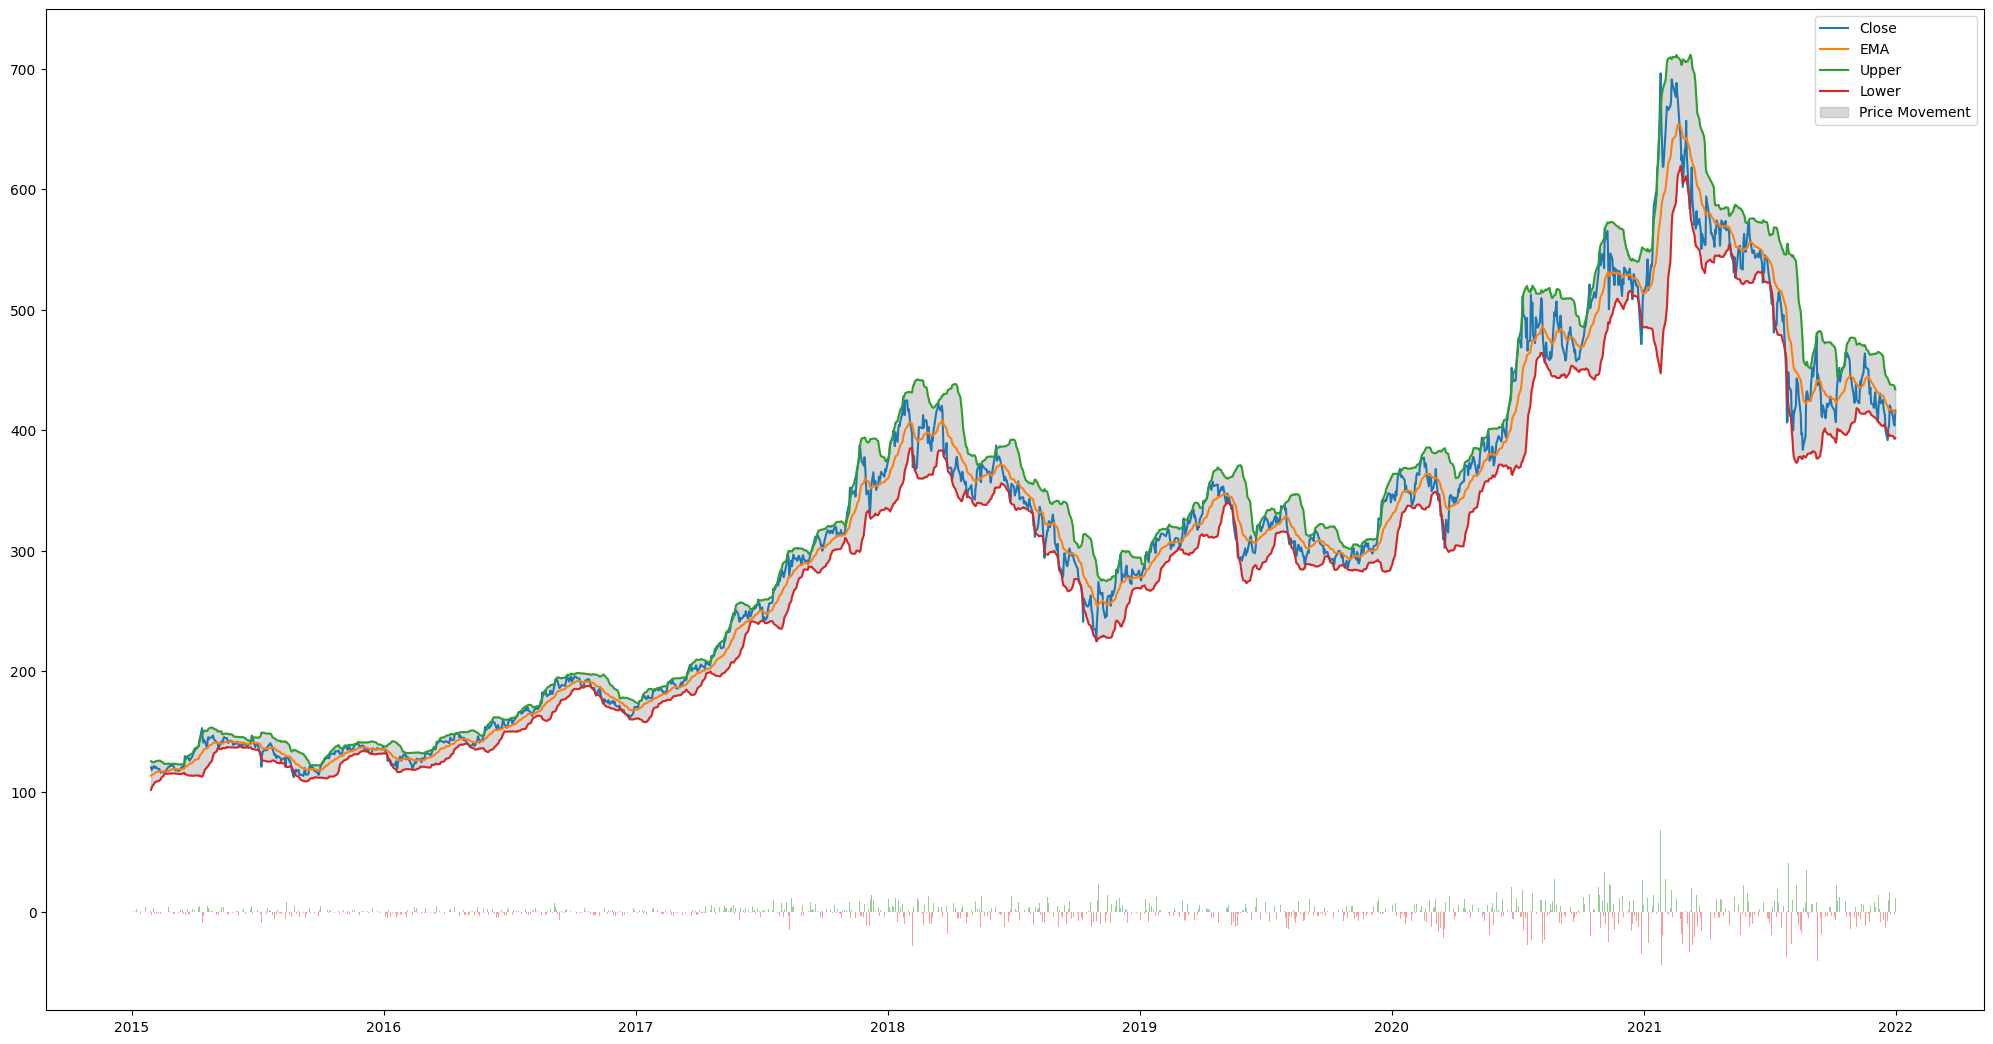

In [ ]:
#Visualizing Bollinger Bands and Price Movements
df.dropna(inplace=True)

plt.figure(figsize=(25, 13))

plt.plot(df[['Close', 'EMA', 'Upper', 'Lower',]])

plt.fill_between(df.index, df['Upper'], df['Lower'], color='grey', alpha=0.3)

plt.bar(data.index, data['Price_Movement'], color=data['Price_Movement'].apply(lambda x: 'g' if x > 0 else 'r'), alpha=0.4)

plt.legend(['Close', 'EMA', 'Upper', 'Lower', 'Price Movement'])

plt.show()

###  Price movements of previous dates

In [ ]:
#Look at the direction of price movement over the past 10 days (+/-)
df['n_Price_Movement'] = data['Price_Movement'].rolling(window=10).sum()


### Hang Seng Index
The closing price of the stock broader market is the most commonly used data point as it is considered the most stable indicator of overall market sentiment in Hong Kong.

In [ ]:

HSI = yf.download(tickers='HSI',
                   start='2015-01-01',
                   end='2022-01-01',
                   interval='1d',
                   auto_adjust=True)
df['HSI'] = HSI['Close']
# Perform forward filling to supplement the NaN values ​​of HSI
df.fillna(method='ffill', inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Volume,Label,High_date,Low_date,EMA,Upper,Lower,k,d,OBV,ATR,n_Price_Movement,HSI
Date,,,,,,,,,,,,,,,,,
2015-01-29,121.486124,121.843438,119.520908,120.235535,15876766,0,0,0,113.424273,125.309661,101.538885,86.788660,90.849951,260982852.0,3.212241,6.878258,24595.800781
2015-01-30,121.039480,121.039480,115.679801,117.913002,31865802,1,0,1,113.851771,124.783446,103.780198,78.658582,86.310468,229117050.0,3.365629,9.022141,24507.099609
2015-02-02,116.037121,122.200756,116.037121,121.307472,19150517,2,1,0,114.561838,124.384655,106.171004,76.422800,80.623348,248267567.0,3.565487,11.434006,0.246000
2015-02-03,121.039481,122.647391,118.806287,120.682175,15596398,0,0,0,115.144727,124.547919,107.356595,77.439060,77.506814,232671169.0,3.585174,9.826088,24554.800781
2015-02-04,121.039476,121.575446,119.074259,119.610229,10304634,1,0,1,115.570013,124.813338,107.939791,81.300837,78.387566,222366535.0,3.507746,4.645050,24679.800781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,426.816805,426.816805,418.072797,419.165802,10313242,0,0,0,417.235404,437.848098,395.565001,49.999974,34.914508,568228496.0,12.180250,-2.914642,23193.599609
2021-12-28,416.979805,418.254962,405.321118,410.239624,20555921,0,0,0,416.569139,437.376808,394.943291,54.743562,47.435869,547672575.0,12.299138,-14.755524,23280.599609
2021-12-29,404.045942,405.867616,401.131263,405.138947,10402269,0,0,0,415.480550,437.212376,393.777904,43.846123,49.529886,537270306.0,12.071226,-13.662506,23086.500000


## Split the dataset

In [ ]:
train_data = df['2015':'2019']
validation_data = df['2020':'2020-12-31']
test_data = df['2021':'2022']

## Build prediction samples

In [ ]:
features = ['Close', 'EMA', 'Upper', 'Lower', 'k', 'd', 'OBV', 'ATR', 'n_Price_Movement', 'HSI']
#2015-2019
x_train = train_data[features]
y_high_train = train_data['High_date']
y_low_train = train_data['Low_date']
#2019-2020
x_validation = validation_data[features]
y_high_validation = validation_data['High_date']
y_low_validation = validation_data['Low_date']
#2020-2021
x_test = test_data[features]
y_high_test = test_data['High_date']
y_low_test = test_data['Low_date']

## Normalization

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

x_train_scaled = scaler.fit_transform(x_train)

x_validation_scaled = scaler.transform(x_validation)

x_test_scaled = scaler.transform(x_test)

# 4. Modelling and evaluation


## Construct Model

### Random Forest

In [ ]:
rf_model_high = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=20, min_samples_leaf=10, class_weight={0: 1, 1: 10}, random_state=0, verbose=3, n_jobs=-1)
rf_model_low = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=20, min_samples_leaf=10, class_weight={0: 1, 1: 10}, random_state=0, verbose=3, n_jobs=-1)

# training model
rf_model_high.fit(x_train_scaled, y_high_train)
rf_model_low.fit(x_train_scaled, y_low_train)

# validate model
y_high_val_pred_rf = rf_model_high.predict(x_validation_scaled)
y_low_val_pred_rf = rf_model_low.predict(x_validation_scaled)



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200building tree 21 of 200

building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
b

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.3s


building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200building tree 167 of 200

building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200building tree 174 of 200

building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200building tree 188 of 200
building tree 189 of 200
building tree 190 of 200

building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200
building tree 1 of 200bui

[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s


building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58

[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    0.3s


building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200building tree 187 of 200
building tree 188 of 200
building tree 189 of 200

building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.5s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


### Logistic Regression

In [ ]:
logistic_model_high = LogisticRegression(C=1, solver='liblinear', random_state=0,  class_weight={0: 1, 1: 10},n_jobs=-1)
logistic_model_low = LogisticRegression(C=1, solver='liblinear', random_state=0, class_weight={0: 1, 1: 10}, n_jobs=-1)

# training model
logistic_model_high.fit(x_train_scaled, y_high_train)
logistic_model_low.fit(x_train_scaled, y_low_train)

# validate model
y_high_val_pred_lr = logistic_model_high.predict(x_validation_scaled)
y_low_val_pred_lr = logistic_model_low.predict(x_validation_scaled)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


### SVM

In [ ]:

svm_model_high = SVC(C=1, kernel='rbf', class_weight={0: 1, 1: 10}, random_state=0)
svm_model_low = SVC(C=1, kernel='rbf', class_weight={0: 1, 1: 10}, random_state=0)

# training model
svm_model_high.fit(x_train_scaled, y_high_train)
svm_model_low.fit(x_train_scaled, y_low_train)

# validate model
y_high_val_pred_svm = svm_model_high.predict(x_validation_scaled)
y_low_val_pred_svm = svm_model_low.predict(x_validation_scaled)


### Decision Tree

In [ ]:

dt_model_high = DecisionTreeClassifier(max_depth=15, class_weight={0: 1, 1: 10}, random_state=0)
dt_model_low = DecisionTreeClassifier(max_depth=15, class_weight={0: 1, 1: 10}, random_state=0)

# training model
dt_model_high.fit(x_train_scaled, y_high_train)
dt_model_low.fit(x_train_scaled, y_low_train)

# validate model
y_high_val_pred_dt = dt_model_high.predict(x_validation_scaled)
y_low_val_pred_dt = dt_model_low.predict(x_validation_scaled)



## Dataset statistics

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Visualize using heatmaps
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
def print_classification_report(y_true, y_pred, title):
    print(title)
    print(classification_report(y_true, y_pred))

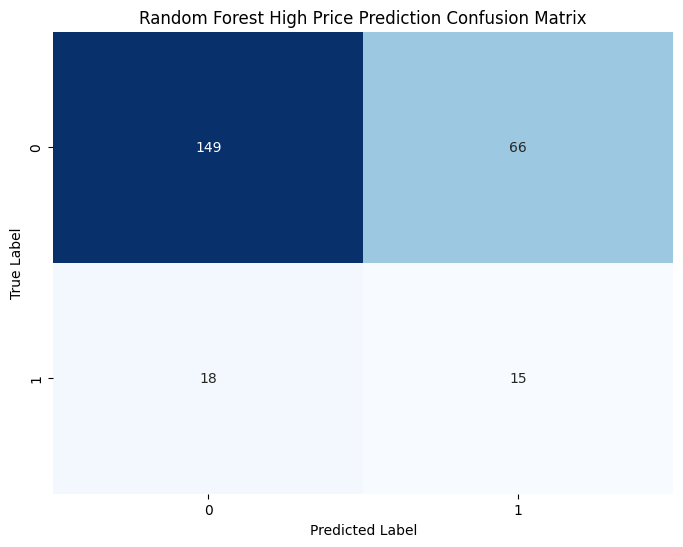

Random Forest High Price Prediction Classification Report
              precision    recall  f1-score   support

           0       0.89      0.69      0.78       215
           1       0.19      0.45      0.26        33

    accuracy                           0.66       248
   macro avg       0.54      0.57      0.52       248
weighted avg       0.80      0.66      0.71       248



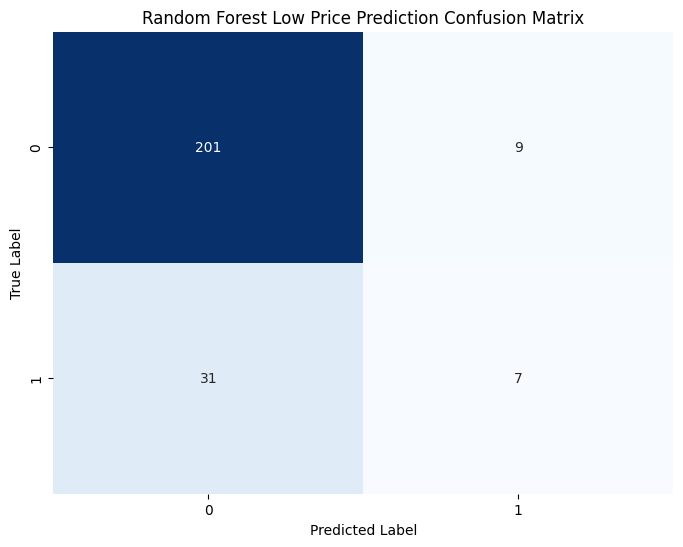

Random Forest Low Price Prediction Classification Report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       210
           1       0.44      0.18      0.26        38

    accuracy                           0.84       248
   macro avg       0.65      0.57      0.58       248
weighted avg       0.80      0.84      0.81       248



In [ ]:
# Visualization of random forest model
plot_confusion_matrix(y_high_validation, y_high_val_pred_rf, "Random Forest High Price Prediction Confusion Matrix")
print_classification_report(y_high_validation, y_high_val_pred_rf, "Random Forest High Price Prediction Classification Report")

plot_confusion_matrix(y_low_validation, y_low_val_pred_rf, "Random Forest Low Price Prediction Confusion Matrix")
print_classification_report(y_low_validation, y_low_val_pred_rf, "Random Forest Low Price Prediction Classification Report")

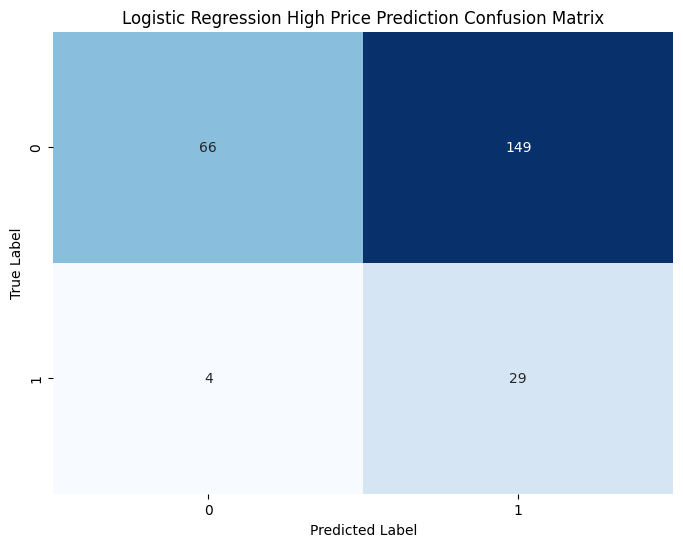

Logistic Regression High Price Prediction Classification Report
              precision    recall  f1-score   support

           0       0.94      0.31      0.46       215
           1       0.16      0.88      0.27        33

    accuracy                           0.38       248
   macro avg       0.55      0.59      0.37       248
weighted avg       0.84      0.38      0.44       248



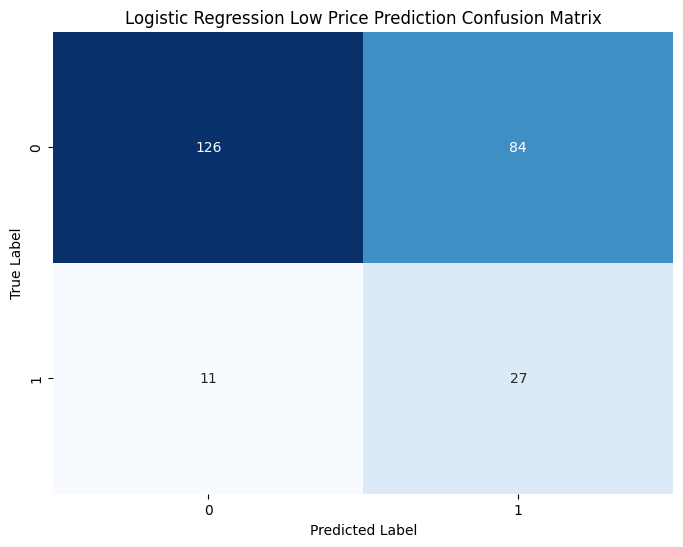

Logistic Regression Low Price Prediction Classification Report
              precision    recall  f1-score   support

           0       0.92      0.60      0.73       210
           1       0.24      0.71      0.36        38

    accuracy                           0.62       248
   macro avg       0.58      0.66      0.54       248
weighted avg       0.82      0.62      0.67       248



In [ ]:
# Visualization of logistic regression model
plot_confusion_matrix(y_high_validation, y_high_val_pred_lr, "Logistic Regression High Price Prediction Confusion Matrix")
print_classification_report(y_high_validation, y_high_val_pred_lr, "Logistic Regression High Price Prediction Classification Report")

plot_confusion_matrix(y_low_validation, y_low_val_pred_lr, "Logistic Regression Low Price Prediction Confusion Matrix")
print_classification_report(y_low_validation, y_low_val_pred_lr, "Logistic Regression Low Price Prediction Classification Report")

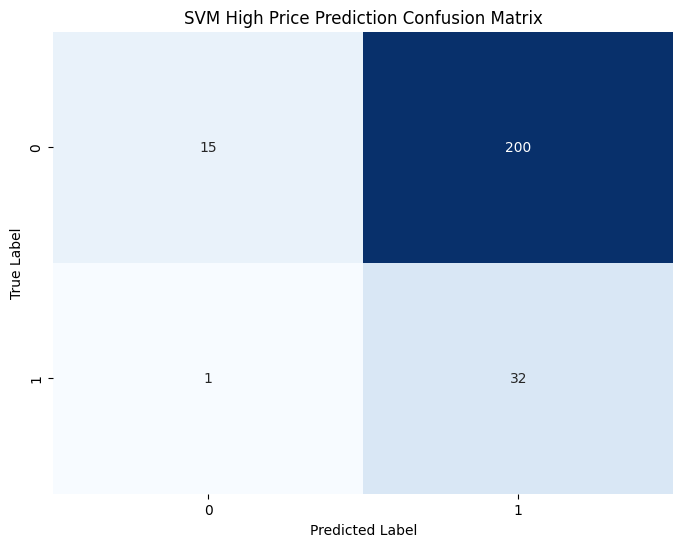

SVM High Price Prediction Classification Report
              precision    recall  f1-score   support

           0       0.94      0.07      0.13       215
           1       0.14      0.97      0.24        33

    accuracy                           0.19       248
   macro avg       0.54      0.52      0.19       248
weighted avg       0.83      0.19      0.14       248



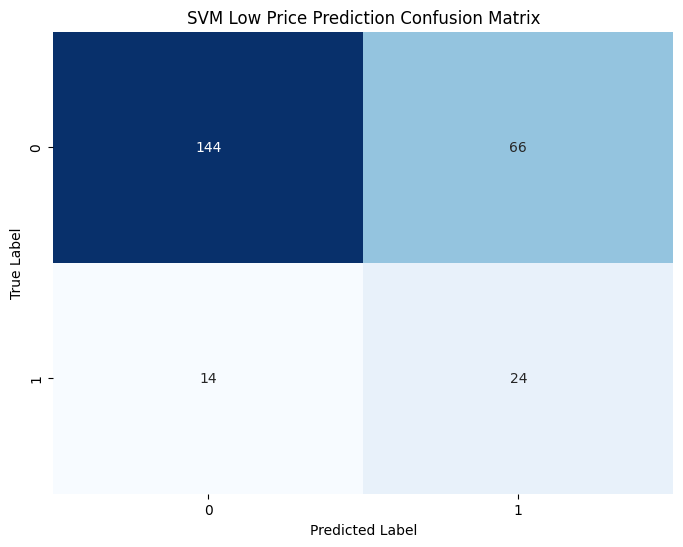

SVM Low Price Prediction Classification Report
              precision    recall  f1-score   support

           0       0.91      0.69      0.78       210
           1       0.27      0.63      0.38        38

    accuracy                           0.68       248
   macro avg       0.59      0.66      0.58       248
weighted avg       0.81      0.68      0.72       248



In [ ]:
#Visualization of SVM model
plot_confusion_matrix(y_high_validation, y_high_val_pred_svm, "SVM High Price Prediction Confusion Matrix")
print_classification_report(y_high_validation, y_high_val_pred_svm, "SVM High Price Prediction Classification Report")

plot_confusion_matrix(y_low_validation, y_low_val_pred_svm, "SVM Low Price Prediction Confusion Matrix")
print_classification_report(y_low_validation, y_low_val_pred_svm, "SVM Low Price Prediction Classification Report")

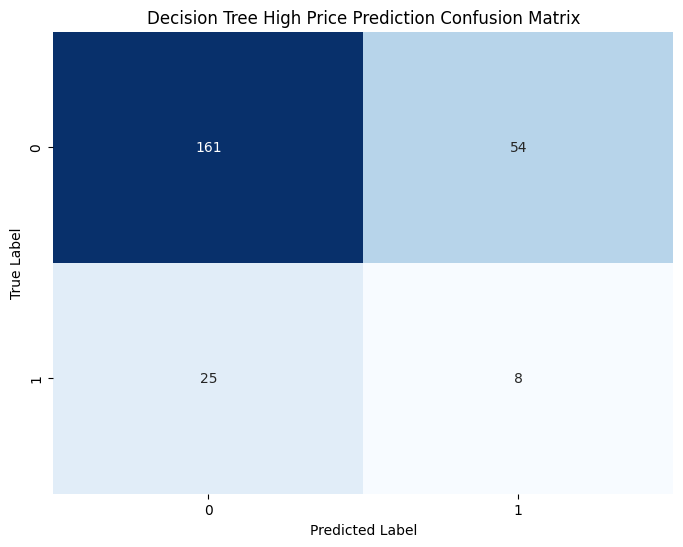

Decision Tree High Price Prediction Classification Report
              precision    recall  f1-score   support

           0       0.87      0.75      0.80       215
           1       0.13      0.24      0.17        33

    accuracy                           0.68       248
   macro avg       0.50      0.50      0.49       248
weighted avg       0.77      0.68      0.72       248



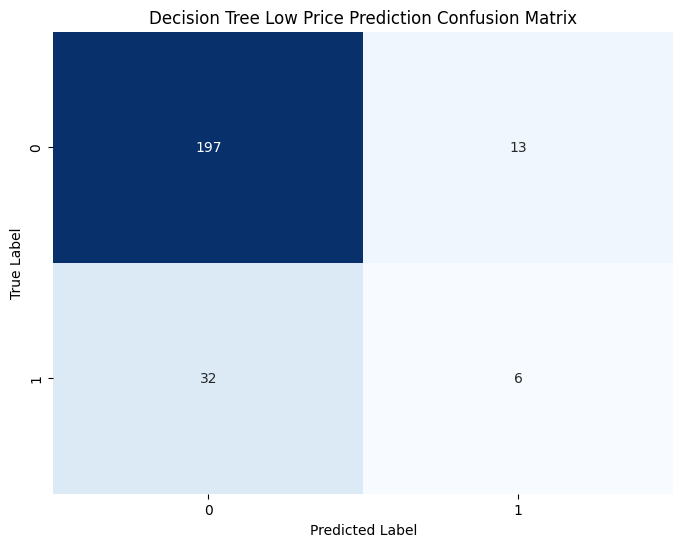

Decision Tree Low Price Prediction Classification Report
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       210
           1       0.32      0.16      0.21        38

    accuracy                           0.82       248
   macro avg       0.59      0.55      0.55       248
weighted avg       0.78      0.82      0.79       248



In [ ]:
#Visualization of dt model
plot_confusion_matrix(y_high_validation, y_high_val_pred_dt, "Decision Tree High Price Prediction Confusion Matrix")
print_classification_report(y_high_validation, y_high_val_pred_dt, "Decision Tree High Price Prediction Classification Report")

plot_confusion_matrix(y_low_validation, y_low_val_pred_dt, "Decision Tree Low Price Prediction Confusion Matrix")
print_classification_report(y_low_validation, y_low_val_pred_dt, "Decision Tree Low Price Prediction Classification Report")

## evaluation metrics

In [ ]:
def evaluate_models(models, y_val, y_preds, model_names):
    accuracies = []
    f1_scores = []

    for y_pred in y_preds:
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        accuracies.append(acc)
        f1_scores.append(f1)

    return accuracies, f1_scores

In [ ]:
# High price date prediction results
y_high_preds = [y_high_val_pred_rf, y_high_val_pred_lr, y_high_val_pred_svm, y_high_val_pred_dt]
# Low price date prediction results
y_low_preds = [y_low_val_pred_rf, y_low_val_pred_lr, y_low_val_pred_svm, y_low_val_pred_dt]

model_names = ['Random Forest', 'Logistic Regression', 'SVM', 'Decision Tree']


accuracies_high, f1_scores_high = evaluate_models(model_names, y_high_validation, y_high_preds, model_names)
accuracies_low, f1_scores_low = evaluate_models(model_names, y_low_validation, y_low_preds, model_names)

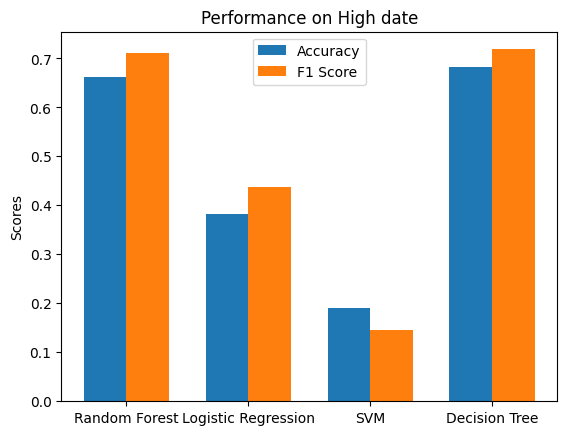

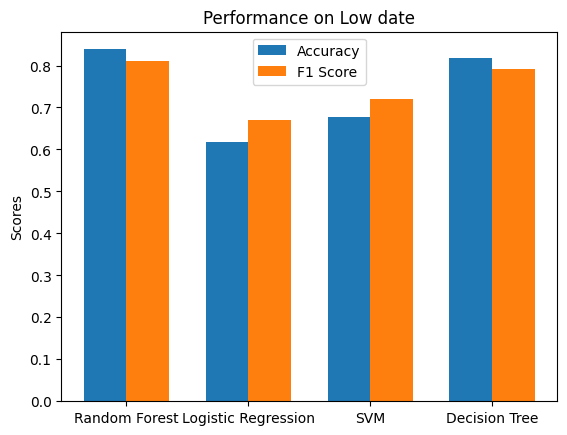

In [ ]:
def plot_model_performance(accuracies, f1_scores, model_names, title):
    x = np.arange(len(model_names))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
    rects2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

    ax.set_ylabel('Scores')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.show()


plot_model_performance(accuracies_high, f1_scores_high, model_names, 'Performance on High date')

plot_model_performance(accuracies_low, f1_scores_low, model_names, 'Performance on Low date')

Based on the above it is concluded that Random Forest and Decision Tree are the best performing models. Random Forest will be as test model.

# 5. Real business performance delivery

##Set up machine prediction signals for buy and sell. (Sell signal for reference)

In [ ]:
y_high_test_pred = rf_model_high.predict(x_test_scaled)
y_low_test_pred = rf_model_low.predict(x_test_scaled)
predictions = pd.DataFrame({
    'High_Prediction': y_high_test_pred,
    'Low_Prediction': y_low_test_pred
})
test_data['signal1'] = np.where(predictions['High_Prediction'] == 1, 1,  #1 means sell
                                  np.where(predictions['Low_Prediction'] == 1, -1, 0))  # -1 means buy, 0 means no operation
test_data

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 112 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished
<ipython-input-58-53d1a40d8bae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['signal1'] = np.where(predictions['High_Prediction'] == 1, 1,  # 1代表卖出


,Open,High,Low,Close,Volume,Label,High_date,Low_date,EMA,Upper,Lower,k,d,OBV,ATR,n_Price_Movement,HSI,signal1
Date,,,,,,,,,,,,,,,,,,
2021-01-04,506.746444,529.450175,506.292421,519.914612,22545919,0,0,0,514.281322,549.096717,485.465170,67.696730,46.146245,1.188397e+09,15.292398,-9.535522,27472.800781,0
2021-01-05,519.460447,532.628612,513.557489,529.904175,20250507,0,0,0,515.769213,548.438389,485.669420,80.534527,64.878377,1.208648e+09,15.562307,3.178467,27649.900391,0
2021-01-06,531.266415,543.980499,531.266415,541.710144,27892115,2,1,0,518.239778,550.387938,484.900468,90.760456,79.663904,1.236540e+09,15.456165,22.249634,27692.300781,1
2021-01-07,527.179732,530.812275,516.281921,516.281921,43257974,1,0,1,518.053315,549.279961,484.691624,84.768496,85.354493,1.193282e+09,16.168455,-3.632690,27548.500000,0
2021-01-08,516.281965,524.909362,515.373860,520.368652,24801900,0,0,0,518.273823,548.114666,484.767142,75.416640,83.648531,1.218084e+09,15.694673,1.816345,27878.199219,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,426.816805,426.816805,418.072797,419.165802,10313242,0,0,0,417.235404,437.848098,395.565001,49.999974,34.914508,5.682285e+08,12.180250,-2.914642,23193.599609,0
2021-12-28,416.979805,418.254962,405.321118,410.239624,20555921,0,0,0,416.569139,437.376808,394.943291,54.743562,47.435869,5.476726e+08,12.299138,-14.755524,23280.599609,0
2021-12-29,404.045942,405.867616,401.131263,405.138947,10402269,0,0,0,415.480550,437.212376,393.777904,43.846123,49.529886,5.372703e+08,12.071226,-13.662506,23086.500000,0


## Check all signals

In [ ]:
# Counting the number of occurrences where 'signal1' equals -1
Prediction_buy_signals = (test_data['signal1'] == -1).sum()
Actually_buy_date = (test_data['Low_date'] == 1).sum()
# Print the result
print(f"Prediction buy signals : {Prediction_buy_signals}")
print(f"Actually_buy_date :{Actually_buy_date}")


Prediction buy signals : 21
Actually_buy_date :33


In [ ]:
# Counting the number of occurrences where 'signal1' equals -1
Prediction_sell_signals = (test_data['signal1'] == 1).sum()
Actually_sell_date = (test_data['High_date'] == 1).sum()
# Print the result
print(f"Prediction sell signals is: {Prediction_sell_signals}")
print(f"Actually_sell_date :{Actually_sell_date}")


Prediction sell signals is: 63
Actually_sell_date :36


## Transaction logic

In [ ]:

def trade(data, g, l, d):
    portfolio = []
    transactions = []
    buy_signals = test_data['signal1'] == -1  # Buy when signal1 is -1

    for i, (price, signal) in enumerate(zip(test_data['Close'], buy_signals)):
        # Check for sell conditions
        for stock in list(portfolio):  # Use a copy of the list to modify it while iterating
            days_held = i - stock['buy_day']
            gain = (price / stock['buy_price'] - 1) * 100

            if gain >= g or gain <= -l or days_held >= d:
                transactions.append({'day': i, 'type': 'sell', 'price': price})
                portfolio.remove(stock)

        # Check for buy signals
        if signal and not portfolio:  # Only buy if not currently holding stock
            portfolio.append({'buy_price': price, 'buy_day': i})
            transactions.append({'day': i, 'type': 'buy', 'price': price})

    return transactions
def calculate_profit(transactions, max_shares=100):
    # Initialize variables
    profit = 0
    current_holding = 0  # Track the current number of shares held

    for transaction in transactions:
        if transaction['type'] == 'buy':
            # Calculate the number of shares you can buy without exceeding the limit
            shares_to_buy = min(max_shares - current_holding, max_shares)
            if shares_to_buy > 0:
                profit -= transaction['price'] * shares_to_buy
                current_holding += shares_to_buy

        elif transaction['type'] == 'sell':
            # Calculate the number of shares you can sell (cannot sell more than you hold)
            shares_to_sell = min(current_holding, max_shares)
            if shares_to_sell > 0:
                profit += transaction['price'] * shares_to_sell
                current_holding -= shares_to_sell

    return profit

## Define Investor Types with Sell signal and check profit
Short-term Investor

Gain (g): Small gain, e.g., 2%
Loss (l): Small loss, e.g., 1%
Days (d): 5 days

Medium-term Investor

Gain (g): Moderate gain, e.g., 5%
Loss (l): Moderate loss, e.g., 3%
Days (d): 10 to 15 days

Long-term Investor

Gain (g): High gain, e.g., 10%
Loss (l): Higher tolerance for loss, e.g., 5%
Days (d): 20 days or more

Random Investor

No structured strategy.
Buys and sells are made randomly.

In [ ]:
# Short-term Investor
g = 2
l = 1
d = 5
transactions = trade(test_data, g, l, d)
profit = calculate_profit(transactions)
print('Profit:', profit)

Profit: -4523.2330322265625


In [ ]:
# Medium-term Investor
g = 5
l = 3
d = 15
transactions = trade(test_data, g, l, d)
profit = calculate_profit(transactions)
print('Profit:', profit)

Profit: -8373.638916015625


In [ ]:
# Long-term Investor
g = 10
l = 5
d = 25
transactions = trade(test_data, g, l, d)
profit = calculate_profit(transactions)
print('Profit:', profit)

Profit: -42343.58215332031


In [ ]:
# Random Investor
g = random.randint(0, 100)
l = random.randint(0, 100)
d = random.randint(0, 100)
transactions = trade(test_data, g, l, d)
profit = calculate_profit(transactions)
print('Profit:', profit)

Profit: -50480.14831542969


## All trade base on the model prediction signal(Reference)

In [ ]:
def calculate_profit_based_on_signals(data, max_shares=100):
    cash = 0
    position = 0  # This tracks the current number of shares held

    for i, row in data.iterrows():
        if row['signal1'] == -1 and position < max_shares:
            # Calculate how many shares can be bought without exceeding the maximum
            shares_to_buy = min(max_shares - position, max_shares)
            position += shares_to_buy
            cash -= row['Close'] * shares_to_buy
        elif row['signal1'] == 1 and position >= max_shares:
            # Sell only if we have shares equal to the max_shares (or more, if logic allows it)
            position -= max_shares
            cash += row['Close'] * max_shares

    # Calculate the final value of the portfolio including unsold stocks
    final_value = cash + position * data.iloc[-1]['Close']
    return final_value
profit = calculate_profit_based_on_signals(test_data)

print('Total profit from trading based on signals:', profit)

Total profit from trading based on signals: -7252.7984619140625
